# Applying Naive Bayes on Amazon fine food reviews Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import sqlite3
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### 2. Connecting to Amazon food review dataset

In [2]:
con=sqlite3.connect('./database.sqlite')
filtered_data=pd.read_sql_query("""select * from reviews where score!=3""",con)
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
actual_score=filtered_data['Score']
PositiveNegative=actual_score.map(partition)
filtered_data['Score']=PositiveNegative
print(filtered_data.shape)
filtered_data.head()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##### 3. Sorting our data on the basis of date and removing the Duplicate reviews

In [3]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print(final.shape)

(364173, 10)


##### 4. we are also removing the rows which has HelpfulnessDenominator greater then HelpfulnessNumerator because its not practically possile 

In [4]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
print(final.shape)

(364171, 10)


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### we are also cleaning our text of html tags , stop words, and puncuations

In [7]:
# find sentences containing HTML tags

import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'most', 'shan', "hasn't", 'isn', 'that', 'hasn', 'wouldn', 'under', 'did', "wouldn't", 'ain', 'or', 'theirs', 'me', 'more', 'ours', 'his', 'into', 'those', 'there', 'ourselves', 'so', "won't", 'had', 'aren', 'why', 'how', 'who', 'any', 'about', 'where', 'when', 'but', 'off', 'is', 'our', 'its', "shouldn't", "haven't", 'ma', 'just', 'over', 'nor', 'each', 've', 'before', 'couldn', 'the', 'them', "she's", 'they', 'have', 'now', 'does', 'and', 'too', 'd', 'shouldn', 'wasn', 'if', 'while', 'only', 'here', 'this', 'don', 'not', 'by', "hadn't", "isn't", 'your', 'can', 'mightn', 'than', 'o', 'again', 'same', 's', 'it', 'do', 'both', 'won', 'as', 'some', 'their', "you've", 'which', 'during', "shan't", "should've", 'between', 'you', 'for', 'to', 'once', 'him', "didn't", 'weren', 'very', 'should', 'didn', 'being', 'll', "it's", 'were', 'am', 'we', 'yours', 're', 'mustn', 'yourself', 'with', 'needn', 'out', 'at', 'was', 'doesn', 'against', 'he', "couldn't", 'up', 'few', 'all', 'myself', 'an', "t

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [11]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##### 6. Here we are Seperating all the review information of user on the basis of their Score i.e positive or negative. 
Then we are taking 306913 positive and 57087 negative reviews respectively from positive and negative data frame and we are concating them together in one data frame bigdata. We are also taking the scores of these 364000 reviews seperately in s1.
We then divide 364000 reviews to train and test data, and we convert the text column of the test and train into BOW. 


In [12]:
total_data=final.sample(364000)

In [13]:
conn = sqlite3.connect('total_data.sqlite')
c=conn.cursor()
conn.text_factory = str
total_data.to_sql('total', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [14]:
positive_data=pd.read_sql_query("""select * from total where score='positive'""",conn)
negative_data=pd.read_sql_query("""select * from total where score='negative'""",conn)

In [15]:
print(positive_data.shape)
print(negative_data.shape)

(306918, 12)
(57082, 12)


In [16]:
positive_data2000=positive_data.head(306913)
negative_data2000=negative_data.head(57087)
bigdata = positive_data2000.append(negative_data2000, ignore_index=True)
print(bigdata.shape)

(363995, 12)


In [17]:
sorted_data=bigdata

In [18]:
#Again sorting our data in Ascending order
sorted_data=bigdata.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [19]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
68380,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
182299,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
211372,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
88567,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
90746,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [20]:
bigdata=sorted_data
s1=bigdata['Score']
print(s1.shape)
print(s1[3])

(363995,)
positive


In [21]:
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(bigdata, s1, test_size=0.3, random_state=0)

In [22]:
#BOW for 254800 Train points
count_vect = CountVectorizer(max_features=27933) #in scikit-learn
big_data = count_vect.fit_transform(X_1['Text'].values)
print(big_data.shape)


(254796, 27933)


In [23]:
#BOW for 109200 Test points
count_vect = CountVectorizer(max_features=27933) #in scikit-learn
test_data = count_vect.fit_transform(X_test['Text'].values)
print(test_data.shape)

(109199, 27933)


##### Standardizing our Train and Test BOW vectors 

In [24]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(109199, 27933)


In [25]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(254796, 27933)


In [26]:
big_data=standardized_data

#### Using Multinomial Naive bayes to Implement Naive bayes using train for Different values of Alpha using the 10 fold cross validation  

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB


In [32]:
# We are training our data for different values of alpha
myList = list(range(0,30))
alphas = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for i in alphas:
    nb = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, big_data, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_k)
import matplotlib.pyplot as plt
# plot misclassification error vs k
plt.plot(neighbors, MSE)
for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each Alpha value is : ", np.round(MSE,3))

NameError: name 'neighbors' is not defined

In [29]:
# We are training our data for different values of alpha 
myList = list(range(0,30))
alphas = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in alphas:
    nb = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, big_data, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_k)

import matplotlib.pyplot as plt
# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,3))

NameError: name 'neighbors' is not defined

##### Because for alpha=29 we are getting the least train error so we select this value of alpha and use our test data to predict final model accuracy 

In [ ]:
nb = MultinomialNB(alpha=21, class_prior=None, fit_prior=True)
nb.fit(X_tr, y_tr)
y_pred = nb.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for alpha = 21 is %d%%' % ( acc))

# Function for Confusion Matrix

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [ ]:
plot_confusion_matrix(cm           = np.array([[ 3088 13961],[15380 76771]]), 
                      normalize    = False,
                      target_names = ['negative(0)', 'positive(1)'],
                      title        = "Confusion Matrix")

#### Confusion matrix , Precision, Recall, F-Score

[[ 3088 13961]
 [15380 76771]]


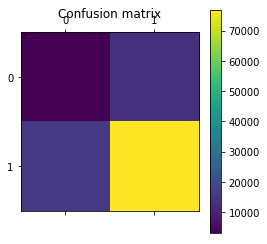

In [321]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(gb)
# cm = metrics.confusion_matrix(y_test, y_pred_class, labels=['FAKE', 'REAL'])
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

In [322]:
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
recall

0.83310002061833299

In [323]:
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print(pre)

0.846129259798


In [324]:
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
F1

0.83956409288998968

##### We are printing the top words which have the highest probablity in  positive and negative reviews.

In [327]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
print("TOP Words with the highest probablity in Negative Reviews \n")
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))


TOP Words with the highest probablity in Negative Reviews 

['µg' 'excerpts' 'excercise' 'sigh' 'excema' 'excellent' 'sights'
 'exceedingly' 'exceeding' 'exceeded']


In [328]:
print("TOP Words with the highest probablity in Positive Reviews \n")
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

TOP Words with the highest probablity in Positive Reviews 

['shifts' 'bombilla' 'ventured' 'punctuated' 'log' 'liquefy' 'venders'
 'punjab' 'linden' 'distracted']


#### Now Doing this same process with TF-idf vectors

In [331]:
#Now we Use TF-IDF vectors to predict our reviews using Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=1362337)
big_data = tf_idf_vect.fit_transform(X_1['Text'].values)
big_data.get_shape()

(254800, 1362337)

In [351]:
y_1=X_1['Score']
y_test=X_test['Score']

In [352]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=1362337)
test_data = tf_idf_vect.fit_transform(X_test['Text'].values)
test_data.get_shape()

(109200, 1362337)

##### Standardizing our Train and Test TF-IDF vectors 

In [353]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

(109200, 1362337)


In [354]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)
big_data=standardized_data

(254800, 1362337)


#### Using Multinomial Naive bayes to Implement Naive bayes using train for Different values of Alpha using the 10 fold cross validation  

In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB



The optimal value of alpha is 1.


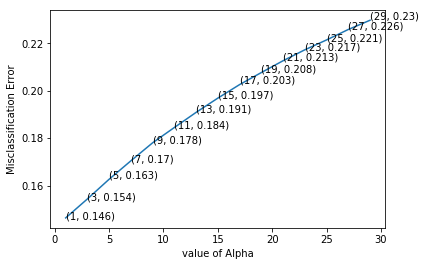

the misclassification error for each Alpha value is :  [ 0.146  0.154  0.163  0.17   0.178  0.184  0.191  0.197  0.203  0.208
  0.213  0.217  0.221  0.226  0.23 ]


In [356]:
# We are training our data for different values of alpha 
myList = list(range(0,30))
alphas = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in alphas:
    nb = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, big_data, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_k)

import matplotlib.pyplot as plt
# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,3))

In [357]:
nb = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
nb.fit(big_data, y_1)
y_pred = nb.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for alpha = 1 is %d%%' % ( acc))


Test accuracy for alpha = 1 is 83%


In [358]:
y_pred.shape


(109200,)

In [359]:
y_test.shape


(109200,)

[[  222 16827]
 [ 1631 90520]]


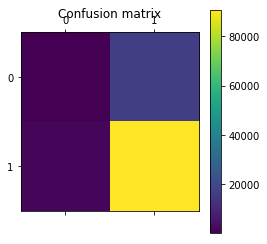

In [360]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(gb)
# cm = metrics.confusion_matrix(y_test, y_pred_class, labels=['FAKE', 'REAL'])
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

In [361]:
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
recall

0.98230078892252937

In [362]:
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print(pre)

0.84324666735


In [363]:
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
F1

0.90747776920069378

##### We are printing the top words which have the highest probablity in  positive and negative reviews.

In [364]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
print("TOP Words with the highest probablity in Negative Reviews \n")
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10]))


TOP Words with the highest probablity in Negative Reviews 

['litter back' 'of snacking' 'of snackmasters' 'of snacks' 'of snacktime'
 'of snacky' 'of snails' 'of snake' 'of snap' 'of snapple']


In [365]:
print("TOP Words with the highest probablity in Positive Reviews \n")
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))

TOP Words with the highest probablity in Positive Reviews 

['recommends 1500' 'tams just' 'tams are' 'tampura and' 'melon br'
 'tampering this' 'tampa st' 'tamp this' 'meloxicam' 'tamp it']


### Conclusion / Summary